In [ ]:
!pip install --upgrade matplotlib

In [ ]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy.random import seed

In [ ]:
stocks_searches = pd.read_csv('stocksSearches.csv', index_col=0)
n_features = stocks_searches.shape[1]
stocks_searches.head()

,btcClose,newsSearches,searches
date,,,
2016-10-02,610.892029,4.0,3.0
2016-10-03,612.132996,4.0,3.0
2016-10-04,610.203979,4.0,3.0
2016-10-05,612.510986,4.0,3.0
2016-10-06,613.020996,4.0,3.0


In [ ]:
import seaborn as sns
from sklearn.metrics import mean_squared_error

def build_prediction_dataframe(training_ts, predictions_ts):
  last_training_predictions = [training_ts.tail(1), predictions_ts]
  last_training_predictions_ts = pd.concat(last_training_predictions)
  last_training_predictions_df = last_training_predictions_ts.reset_index()
  last_training_predictions_df['positive_delta'] = last_training_predictions_df.apply(lambda row: row.name > 0 and last_training_predictions_df.loc[row.name-1, :][last_training_predictions_df.columns[1]] < row[last_training_predictions_df.columns[1]], axis=1)
  predictions_df = last_training_predictions_df.iloc[1: , :][['positive_delta']]
  return predictions_df

def add_row_confusion_matrix(list_of_cm, df_row):
  row = 0
  column = 0
  if df_row.positive_delta_predict:
    column = 1
  if df_row.positive_delta_actual:
    row = 1
  list_of_cm[df_row.name-1][row, column] += 1
  return list_of_cm

def evaluate(model, ts, n_evaluations=10, n_test=3, n_steps=1, n_epochs=100, batch_size=16):
  total_hits = 0
  total_tries = 0
  confusion_matrix = [np.zeros((2,2)), np.zeros((2,2)), np.zeros((2,2))]
  train_evaluate = ts[:-n_evaluations*n_test]
  last_training = train_evaluate[-n_steps:]
  print('Iteration 1 started')
  model.train(train_evaluate, n_epochs, batch_size)

  for i in reversed(range(1, n_evaluations + 1)):
    test_evaluate = ts[-n_test*i:]
    test_evaluate = test_evaluate[:n_test]
    steps_to_predict = pd.concat([last_training, test_evaluate])

    predictions = model.predict(steps_to_predict)
    print("predictions", predictions)
    predictions = predictions.reshape(predictions.shape[0])
    predictions_ts = pd.DataFrame({test_evaluate.columns[0]: predictions}, test_evaluate.index)

    predictions_df = build_prediction_dataframe(last_training, predictions_ts)
    predictions_df.rename(columns={'positive_delta': 'positive_delta_predict'}, inplace=True)

    test_df = build_prediction_dataframe(last_training, test_evaluate)
    test_df.rename(columns={'positive_delta': 'positive_delta_actual'}, inplace=True)

    predictions_and_test = pd.concat([test_df, predictions_df], axis=1)
    predictions_and_test['equal'] = predictions_and_test.apply(lambda row: row['positive_delta_actual'] == row['positive_delta_predict'], axis=1)
    predictions_and_test.apply(lambda row: add_row_confusion_matrix(confusion_matrix, row), axis=1)

    hits = predictions_and_test['equal'].sum()
    print('Accuracy: {}/{}'.format(hits, predictions_and_test.shape[0]))
    total_hits += hits
    total_tries += predictions_and_test.shape[0]

    print('Iteration {} started'.format(n_evaluations+1-i))
    new_train = pd.concat([last_training, test_evaluate])
    model.retrain(new_train, epochs=1, batch_size=len(new_train), validation_split=0)
    last_training = new_train[-n_steps:]

  print('Total hits: {}. Total tries: {}. Accuracy: {:0.2f}'.format(total_hits, total_tries, total_hits / total_tries))
  
  return confusion_matrix

def plot_confusion_matrix(confusion_matrix):
  fig, axs = plt.subplots(2, 2)
  fig.supxlabel('Predicted')
  fig.supylabel('Actual')
  for i in range(0, len(confusion_matrix)):
    ax = axs[int(i/2), i%2]
    ax.title.set_text('Index {}'.format(i+1))
    sns.heatmap(data=confusion_matrix[i], annot=True, cbar=False, ax=ax)
  sum_cm = sum(confusion_matrix)
  axs[1,1].title.set_text('Total')
  sns.heatmap(data=sum_cm, annot=True, cbar=False, ax=axs[1,1])

def print_effectiveness_day(cm, day):
  hits = cm[0][0] + cm[1][1]
  total = hits + cm[0][1] + cm[1][0]
  print("Day:", day, "Accuracy:", hits / total)

def print_effectiveness_by_day(confusion_matrix_list):
  for i in range(len(confusion_matrix_list)):
    print_effectiveness_day(confusion_matrix_list[i], i+1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10800     
_________________________________________________________________
dense (Dense)                (None, 3)                 153       
Total params: 10,953
Trainable params: 10,953
Non-trainable params: 0
_________________________________________________________________
None
Iteration 1 started
Epoch 1/50
81/81 [==============================] - 2s 9ms/step - loss: 0.1326 - accuracy: 0.0000e+00 - val_loss: 0.0651 - val_accuracy: 0.0000e+00
Epoch 2/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0269 - accuracy: 0.0000e+00 - val_loss: 0.0191 - val_accuracy: 0.0000e+00
Epoch 3/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0256 - accuracy: 0.0000e+00 - val_loss: 0.0287 - val_accuracy: 0.0000e+00
Epoch 4/50
81/81 [===========================

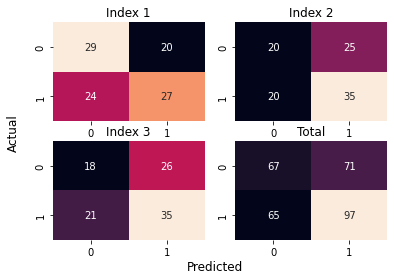

In [ ]:
# from sklearn.metrics import mean_absolute_percentage_error
from VanillaMultivariableLSTM import VanillaLSTM
from StackedMultivariableLSTM import StackedLSTM
from BidirectionalMultivariableLSTM import BidirectionalLSTM
from ConvMultivariableLSTM import ConvLSTM
from CnnMultivariableLSTM import CnnLSTM

epochs = 50
batch_size = 16
n_steps = 5
n_outputs = 3
n_evaluations = 100
n_neurons = 50
n_seed = 0
optimizer = 'adam'
loss = 'mean_absolute_error'

seed(n_seed)
tf.random.set_seed(n_seed)
model = VanillaLSTM(n_neurons=n_neurons, n_steps=n_steps, n_features=3, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, stocks_searches, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)
plot_confusion_matrix(cm)
print_effectiveness_by_day(cm)

In [ ]:
def score_from_cm(confusion_matrix_array):
  total_cm = sum(confusion_matrix_array)
  total_score = total_cm[0][0] + total_cm[1][1]

  score_by_index = [x[0][0] + x[1][1] for x in confusion_matrix_array]
  score =  { 
      'total_score': total_score,
      'score_by_index': score_by_index
    }
  return score

def score_model_from_dict(score_dict):
  n_index = len(score_dict['score_by_index'])
  score = score_dict['total_score'] * pow(10, n_index * 2)
  for i in range(n_index):
    score += score_dict['score_by_index'][i] * pow(10, (n_index-(i+1))*2)
  print("score:", score)
  return score

def take_score(elem):
    return elem['score']

def grid_search(model_class, ts, n_features, seeds=[0], optimizers=['adam'], losses=['mean_squared_error'], neurons=[50], steps=[1], n_outputs=3, epochs=[50], batch_sizes=[16], n_evaluations=10):
  models= list()
  n_combinations = len(seeds) * len(optimizers) * len(losses) * len(neurons) * len(steps) * len(epochs) * len(batch_sizes)
  print("Number of combinations to test:", n_combinations)
  starting_time = time.time()
  for n_seed in seeds:
    for optimizer in optimizers:
      for loss in losses:
        for n_neurons in neurons:
          for n_steps in steps:
            for n_epochs in epochs:
              for batch_size in batch_sizes:
                print("Seed: {}, Optimizer: {}, Neurons: {}, Steps: {}, Epochs: {}, Batch: {}".format(n_seed, optimizer, n_neurons, n_steps, n_epochs, batch_size))
                epoch_starting_time = time.time()
                seed(n_seed)
                tf.random.set_seed(n_seed)
                model = model_class(n_neurons=n_neurons, n_features=n_features, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)
                confusion_matrix = evaluate(model, ts, n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=n_epochs)
                score_dict = score_from_cm(confusion_matrix)
                score = score_model_from_dict(score_dict)
                parameters = {
                    'model': str(model_class),
                    'seed': n_seed,
                    'optimizer': str(optimizer),
                    'loss': loss,
                    'neurons': n_neurons,
                    'steps': n_steps,
                    'epochs': n_epochs,
                    'batch_size': batch_size
                }
                model_score = {
                    'model': model,
                    'parameters': parameters,
                    'score': score,
                    'cm': confusion_matrix
                }
                models.append(model_score)
                models = sorted(models, key=take_score, reverse=True)
                print("Combinations tested", len(models), "/", n_combinations)
                epoch_ending_time = time.time()
                print("Epoch time(s):", epoch_ending_time - epoch_starting_time)
                print("Time since starting(min):", (epoch_ending_time - starting_time) / 60)
                models_left = n_combinations - len(models)
                time_per_model_s = (epoch_ending_time - starting_time) / len(models)
                print("Time left (min):", (time_per_model_s * models_left) / 60)
  return models

In [ ]:
models = grid_search(VanillaLSTM, stocks_searches, n_features=n_features, seeds=[0], steps=[5, 7, 14, 30], epochs=[30, 50, 70], neurons=[30, 50, 70], n_outputs=n_outputs, n_evaluations=n_evaluations, optimizers=['adam'], losses=['mean_squared_error'])

Streaming output truncated to the last 5000 lines.
 [53905.746]]
Accuracy: 1/3
Iteration 69 started
1/1 [==============================] - 0s 33ms/step - loss: 0.1301 - accuracy: 0.0000e+00
predictions [[54951.125]
 [56958.883]
 [57082.652]]
Accuracy: 1/3
Iteration 70 started
1/1 [==============================] - 0s 12ms/step - loss: 0.1469 - accuracy: 0.0000e+00
predictions [[59221.797]
 [61821.44 ]
 [61545.105]]
Accuracy: 3/3
Iteration 71 started
1/1 [==============================] - 0s 11ms/step - loss: 0.0052 - accuracy: 0.0000e+00
predictions [[62983.375]
 [65546.55 ]
 [64792.895]]
Accuracy: 1/3
Iteration 72 started
1/1 [==============================] - 0s 10ms/step - loss: 0.2162 - accuracy: 0.0000e+00
predictions [[57489.945]
 [59472.38 ]
 [58034.   ]]
Accuracy: 2/3
Iteration 73 started
1/1 [==============================] - 0s 14ms/step - loss: 0.1230 - accuracy: 0.0000e+00
predictions [[55118.85 ]
 [55620.176]
 [54900.023]]
Accuracy: 1/3
Iteration 74 started
1/1 [==========

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


1/1 [==============================] - 0s 6ms/step - loss: 0.2340 - accuracy: 0.0000e+00
predictions [[46707.5  ]
 [45784.75 ]
 [47664.766]]
Accuracy: 2/3
Iteration 55 started
1/1 [==============================] - 0s 6ms/step - loss: 0.0024 - accuracy: 0.0000e+00
predictions [[41326.6  ]
 [40178.098]
 [41971.227]]
Accuracy: 1/3
Iteration 56 started
1/1 [==============================] - 0s 6ms/step - loss: 0.1477 - accuracy: 0.0000e+00
predictions [[42725.47]
 [41040.74]
 [42548.54]]
Accuracy: 2/3
Iteration 57 started
1/1 [==============================] - 0s 7ms/step - loss: 0.1321 - accuracy: 0.0000e+00
predictions [[42497.406]
 [41330.996]
 [42189.48 ]]
Accuracy: 2/3
Iteration 58 started
1/1 [==============================] - 0s 6ms/step - loss: 0.2947 - accuracy: 0.0000e+00
predictions [[45608.246]
 [44346.523]
 [44607.16 ]]
Accuracy: 1/3
Iteration 59 started
1/1 [==============================] - 0s 8ms/step - loss: 0.4710 - accuracy: 0.0000e+00
predictions [[52464.69 ]
 [51116.9

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Accuracy: 3/3
Iteration 93 started
1/1 [==============================] - 0s 7ms/step - loss: 0.0397 - accuracy: 0.0000e+00
predictions [[33546.914]
 [33695.324]
 [33160.664]]
Accuracy: 2/3
Iteration 94 started
1/1 [==============================] - 0s 7ms/step - loss: 0.0041 - accuracy: 0.0000e+00
predictions [[33661.285]
 [33587.484]
 [33037.57 ]]
Accuracy: 1/3
Iteration 95 started
1/1 [==============================] - 0s 7ms/step - loss: 0.0044 - accuracy: 0.0000e+00
predictions [[33911.234]
 [33718.76 ]
 [33175.715]]
Accuracy: 2/3
Iteration 96 started
1/1 [==============================] - 0s 7ms/step - loss: 0.0061 - accuracy: 0.0000e+00
predictions [[35110.02 ]
 [34914.027]
 [34232.28 ]]
Accuracy: 0/3
Iteration 97 started
1/1 [==============================] - 0s 7ms/step - loss: 4.1627e-04 - accuracy: 0.0000e+00
predictions [[35293.777]
 [35206.414]
 [34527.043]]
Accuracy: 2/3
Iteration 98 started
1/1 [==============================] - 0s 9ms/step - loss: 0.0020 - accuracy: 0.0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


predictions [[19976.188]
 [19936.23 ]
 [20055.406]]
Accuracy: 2/3
Iteration 24 started
1/1 [==============================] - 0s 21ms/step - loss: 0.0226 - accuracy: 0.0000e+00
predictions [[17894.422]
 [17742.861]
 [17424.812]]
Accuracy: 0/3
Iteration 25 started
1/1 [==============================] - 0s 14ms/step - loss: 7.8074e-04 - accuracy: 0.0000e+00
predictions [[16215.064]
 [15962.12 ]
 [15518.148]]
Accuracy: 1/3
Iteration 26 started
1/1 [==============================] - 0s 13ms/step - loss: 0.0308 - accuracy: 0.0000e+00
predictions [[16785.701]
 [16356.25 ]
 [16224.398]]
Accuracy: 1/3
Iteration 27 started
1/1 [==============================] - 0s 14ms/step - loss: 0.0206 - accuracy: 0.0000e+00
predictions [[17470.248]
 [17013.322]
 [17231.617]]
Accuracy: 1/3
Iteration 28 started
1/1 [==============================] - 0s 16ms/step - loss: 0.0034 - accuracy: 0.0000e+00
predictions [[18099.514]
 [17737.35 ]
 [18293.092]]
Accuracy: 1/3
Iteration 29 started
1/1 [===================

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


1/1 [==============================] - 0s 8ms/step - loss: 5.3321e-04 - accuracy: 0.0000e+00
predictions [[10981.124]
 [10954.874]
 [11016.695]]
Accuracy: 1/3
Iteration 7 started
1/1 [==============================] - 0s 7ms/step - loss: 3.7030e-04 - accuracy: 0.0000e+00
predictions [[11115.79 ]
 [11070.229]
 [11126.668]]
Accuracy: 1/3
Iteration 8 started
1/1 [==============================] - 0s 7ms/step - loss: 9.3109e-05 - accuracy: 0.0000e+00
predictions [[11268.657]
 [11231.004]
 [11265.825]]
Accuracy: 1/3
Iteration 9 started
1/1 [==============================] - 0s 6ms/step - loss: 4.7485e-05 - accuracy: 0.0000e+00
predictions [[11708.23 ]
 [11686.969]
 [11699.766]]
Accuracy: 1/3
Iteration 10 started
1/1 [==============================] - 0s 7ms/step - loss: 1.1570e-04 - accuracy: 0.0000e+00
predictions [[11808.643]
 [11816.055]
 [11820.602]]
Accuracy: 2/3
Iteration 11 started
1/1 [==============================] - 0s 6ms/step - loss: 3.0857e-04 - accuracy: 0.0000e+00
prediction

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


1/1 [==============================] - 0s 11ms/step - loss: 0.0566 - accuracy: 0.0000e+00
predictions [[43238.457]
 [42199.32 ]
 [42136.19 ]]
Accuracy: 3/3
Iteration 82 started
1/1 [==============================] - 0s 16ms/step - loss: 0.0862 - accuracy: 0.0000e+00
predictions [[34411.914]
 [32701.96 ]
 [33381.74 ]]
Accuracy: 2/3
Iteration 83 started
1/1 [==============================] - 0s 13ms/step - loss: 0.0471 - accuracy: 0.0000e+00
predictions [[30747.598]
 [28640.697]
 [29578.084]]
Accuracy: 1/3
Iteration 84 started
1/1 [==============================] - 0s 8ms/step - loss: 0.2165 - accuracy: 0.0000e+00
predictions [[31300.229]
 [29166.271]
 [30130.16 ]]
Accuracy: 1/3
Iteration 85 started
1/1 [==============================] - 0s 7ms/step - loss: 0.0869 - accuracy: 0.0000e+00
predictions [[31478.13 ]
 [29861.334]
 [30569.77 ]]
Accuracy: 2/3
Iteration 86 started
1/1 [==============================] - 0s 6ms/step - loss: 0.1269 - accuracy: 0.0000e+00
predictions [[31761.7  ]
 [2

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


1/1 [==============================] - 0s 9ms/step - loss: 0.0424 - accuracy: 0.0000e+00
predictions [[34282.164]
 [34761.316]
 [34153.465]]
Accuracy: 2/3
Iteration 38 started
1/1 [==============================] - 0s 11ms/step - loss: 0.0695 - accuracy: 0.0000e+00
predictions [[51074.008]
 [50529.277]
 [50124.52 ]]
Accuracy: 3/3
Iteration 39 started
1/1 [==============================] - 0s 8ms/step - loss: 0.4190 - accuracy: 0.0000e+00
predictions [[46421.105]
 [46717.168]
 [45564.152]]
Accuracy: 0/3
Iteration 40 started
1/1 [==============================] - 0s 8ms/step - loss: 0.2236 - accuracy: 0.0000e+00
predictions [[35391.34 ]
 [35928.984]
 [35421.11 ]]
Accuracy: 1/3
Iteration 41 started
1/1 [==============================] - 0s 13ms/step - loss: 0.0012 - accuracy: 0.0000e+00
predictions [[29575.729]
 [30593.283]
 [30061.824]]
Accuracy: 3/3
Iteration 42 started
1/1 [==============================] - 0s 9ms/step - loss: 0.1012 - accuracy: 0.0000e+00
predictions [[26960.904]
 [27

In [ ]:
models[0]

{'cm': [array([[33., 16.],
         [20., 31.]]), array([[24., 21.],
         [25., 30.]]), array([[23., 21.],
         [26., 30.]])],
 'model': <VanillaMultivariableLSTM.VanillaLSTM at 0x7fbf8173ccd0>,
 'parameters': {'batch_size': 16,
  'epochs': 30,
  'loss': 'mean_squared_error',
  'model': "<class 'VanillaMultivariableLSTM.VanillaLSTM'>",
  'neurons': 50,
  'optimizer': 'adam',
  'seed': 0,
  'steps': 14},
 'score': 171645453.0}

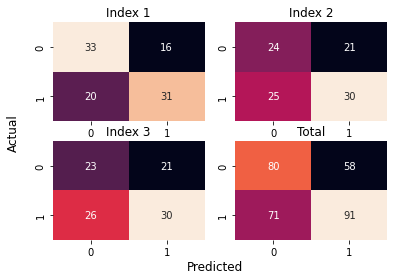

In [ ]:
plot_confusion_matrix(models[0]['cm'])

In [ ]:
print_effectiveness_by_day(models[0]['cm'])

Day: 1 Accuracy: 0.64
Day: 2 Accuracy: 0.54
Day: 3 Accuracy: 0.53
